In [314]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('../..')))

from database.CERNMongoClient import CERNMongoClient
from postprocessing.Segment import Segment
from preprocessing import feature_extraction, preprocessing
from anomaly_detection.GMM import GMM
from postprocessing import segmentation

# auto-load changes in imported modules
%autoreload 2

In [316]:
db = CERNMongoClient()

## Create empty segments

In [317]:
states = db.query('MKI.UA23.STATE:MODE',start="2016-06-01",end="2016-09-01")

Fetching data for pattern MKI.UA23.STATE:MODE from 2016-06-01 to 2016-09-01



In [318]:
segments = []
started_segment = False
for index, row in states.itertuples():
    if not started_segment:
        if row == "1": # on
            start = index
            started_segment = True
    else:
        if row == "3" or row =="2" or row == "4": # standby or off or fault
            segments.append(Segment(ts_min=start,ts_max=index))
            started_segment = False

In [319]:
print('Number of segments:', len(segments))
#for segment in segments:
#    print(segment)

Number of segments: 446


In [320]:
lengths = [s.length_time() for s in segments]

In [321]:
indices = pd.Series(lengths).sort_values(ascending=False).index[:-10]

In [322]:
for index in indices:
    print(segments[index], 'length: ', lengths[index])

Segment from 2016-08-23 12:36:27.322999954 to 2016-08-24 04:41:42.318000078 length:  0 days 16:05:14.995000
Segment from 2016-08-18 05:38:21.112999916 to 2016-08-18 14:57:16.457999945 length:  0 days 09:18:55.345000
Segment from 2016-08-02 20:19:53.604000092 to 2016-08-03 04:58:00.165999889 length:  0 days 08:38:06.561999
Segment from 2016-07-28 12:42:46.644000053 to 2016-07-28 20:56:16.292999983 length:  0 days 08:13:29.648999
Segment from 2016-08-15 11:59:17.059999943 to 2016-08-15 18:21:57.207000017 length:  0 days 06:22:40.147000
Segment from 2016-07-28 06:37:47.769000053 to 2016-07-28 12:39:04.595000029 length:  0 days 06:01:16.825999
Segment from 2016-06-02 03:11:51.720000029 to 2016-06-02 08:02:33.579999924 length:  0 days 04:50:41.859999
Segment from 2016-08-23 07:38:13.322999954 to 2016-08-23 12:23:14.138999939 length:  0 days 04:45:00.815999
Segment from 2016-06-09 10:10:40.328000069 to 2016-06-09 14:52:54.911000013 length:  0 days 04:42:14.582999
Segment from 2016-08-30 17:5

Mean of segment length: 3453.3533161418745 s
Median of segment length: 1382.8070000415 s


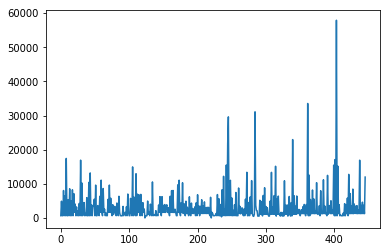

In [323]:
seconds=[l.total_seconds() for l in lengths]
print('Mean of segment length:', np.mean(seconds), 's')
print('Median of segment length:', np.median(seconds), 's')
plt.plot(seconds)

## Assign scored data to segments
adapted from 180518-Segment-anomaly_score_methods by Armin Halilovic

In [324]:
df = feature_extraction.load_features_from_file(beam=1)
df_scaled = preprocessing.scale_robust(df)

Loading file '/Users/thiebout/master/cernthesis-2019/src/../data-cern/features-b1-sw_10min'.
File not found, loading '/Users/thiebout/master/cernthesis-2019/src/../data-cern/features-b1-sw_10min-2018_12_10.csv' instead.



### Fit detector, score data, split into segments

In [326]:
detector = GMM(n_components=3, covariance_type="tied", verbose=1)
df_scored = detector.fit_and_append_scores(df_scaled)

Initialization 0
Initialization converged: True


In [327]:
display(df_scored.tail())

LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
timestamps                                              
2016-08-31 14:09:50                      1.915772e+14   
2016-08-31 14:10:57                      2.020052e+14   
2016-08-31 14:12:04                      2.124713e+14   
2016-08-31 14:13:11                      2.232228e+14   
2016-08-31 14:14:19                      2.340110e+14   

                     LHC.BCTFR.A6R4.B1:BEAM_INTENSITY:SW_MEAN_DIFF_600_s  \
timestamps                                                                 
2016-08-31 14:09:50                                       4.227877e+13     
2016-08-31 14:10:57                                       4.212853e+13     
2016-08-31 14:12:04                                       4.201961e+13     
2016-08-31 14:13:11                                       4.220334e+13     
2016-08-31 14:14:19                                       4.227871e+13     

                     LHC.BQM.B1:BUNCH_LENGTH_MEAN  \
timestamps                                          
2016-08-31 14:09:50                  1.210000e-09   
2016-08-31 14:10:57                  1.190000e-09   
2016-08-31 14:12:04                  1.190000e-09   
2016-08-31 14:13:11                  1.190000e-09   
2016-08-31 14:14:19                  1.190000e-09   

                     LHC.BQM.B1:BUNCH_LENGTH_MEAN:SW_MEAN_DIFF_600_s  \
timestamps                                                             
2016-08-31 14:09:50                                     3.216667e-11   
2016-08-31 14:10:57                                     1.036667e-11   
2016-08-31 14:12:04                                     8.300000e-12   
2016-08-31 14:13:11                                     6.666667e-12   
2016-08-31 14:14:19                                     5.333333e-12   

                     MKI.A5L2.B1:PRESSURE  \
timestamps                                  
2016-08-31 14:09:50                   4.3   
2016-08-31 14:10:57                   4.3   
2016-08-31 14:12:04                   4.8   
2016-08-31 14:13:11                   4.8   
2016-08-31 14:14:19                   5.3   

                     MKI.A5L2.B1:PRESSURE:SW_MEAN_DIFF_600_s  \
timestamps                                                     
2016-08-31 14:09:50                                13.378788   
2016-08-31 14:10:57                                10.333333   
2016-08-31 14:12:04                                15.439394   
2016-08-31 14:13:11                                12.393939   
2016-08-31 14:14:19                                17.393939   

                     MKI.A5L2.B1:PRESSURE:SW_SUM_600_s  \
timestamps                                               
2016-08-31 14:09:50                           3.531726   
2016-08-31 14:10:57                           3.699983   
2016-08-31 14:12:04                           3.920141   
2016-08-31 14:13:11                           4.088398   
2016-08-31 14:14:19                           4.314415   

                     MKI.A5L2.B1:TEMP_MAGNET_DOWN  \
timestamps                                          
2016-08-31 14:09:50                      0.473684   
2016-08-31 14:10:57                      0.473684   
2016-08-31 14:12:04                      0.473684   
2016-08-31 14:13:11                      0.473684   
2016-08-31 14:14:19                      0.473684   

                     MKI.A5L2.B1:TEMP_MAGNET_DOWN:SW_MEAN_DIFF_600_s  \
timestamps                                                             
2016-08-31 14:09:50                                        -0.410359   
2016-08-31 14:10:57                                        -0.410359   
2016-08-31 14:12:04                                        -0.410359   
2016-08-31 14:13:11                                        -0.410359   
2016-08-31 14:14:19                                        -0.410359   

                     MKI.A5L2.B1:TEMP_MAGNET_DOWN:SW_SUM_600_s    ...     \
timestamps                                                        ...      
2016-08-31

In [330]:
seg = segmentation._create_empty_segments(states)

In [331]:
for s in seg:
    print(s)

Segment from 2016-06-01 00:01:58.276000023 to 2016-06-01 00:13:05.427999973
Segment from 2016-06-01 00:54:56.969000101 to 2016-06-01 02:16:42.051000118
Segment from 2016-06-01 06:24:12.313999891 to 2016-06-01 06:35:19.474999905
Segment from 2016-06-01 07:36:35.289999962 to 2016-06-01 07:47:42.451999903
Segment from 2016-06-01 07:59:04.595999956 to 2016-06-01 10:13:06.394000053
Segment from 2016-06-01 11:27:51.382999897 to 2016-06-01 11:38:58.545000076
Segment from 2016-06-01 12:01:06.838999987 to 2016-06-01 13:49:01.295000076
Segment from 2016-06-02 02:41:26.318000078 to 2016-06-02 02:52:33.470999956
Segment from 2016-06-02 03:11:51.720000029 to 2016-06-02 08:02:33.579999924
Segment from 2016-06-03 03:19:49.716000080 to 2016-06-03 03:30:56.864000082
Segment from 2016-06-03 07:11:39.773000002 to 2016-06-03 07:22:46.928999901
Segment from 2016-06-03 08:06:25.505000114 to 2016-06-03 09:35:51.707999945
Segment from 2016-06-03 11:07:28.931999922 to 2016-06-03 11:18:36.095999956
Segment from

In [332]:
segments = segmentation.df_to_segments_by_ipoc_state(df_scored, states)

Skipped tuple with index 2016-08-03 12:03:18 and score 0.0008197182952708311
Skipped tuple with index 2016-08-03 13:02:20 and score 0.0009583800284263089
Skipped tuple with index 2016-08-22 17:27:51 and score 0.001104483948453543
